In [1]:
import os
import pandas as pd
from collections import Counter
import numpy as np
import random
import json
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import mean_squared_error 
import igraph
from functools import reduce
from itertools import product
import regex as re

from modules.support_functions import Utils
from modules.Modularity import RecursiveModularity

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from concurrent.futures import ThreadPoolExecutor
#supernoder files:

#вариант, который считает РАЗНЫЕ типы мотивов одного и того же размера
from SuperNoder_diff_types.manager import Manager as Manager_types 

#вариант, который считает все мотивы одного размера вместе
from SuperNoder.manager import Manager as Manager

from modules.support_functions import Utils
import pickle

In [2]:
Read = True

**Запустите или клетку ниже, чтоб загрузить и отфлитровать данные (дольше), или клетку ниже через одну, чтоб загрузить уже отфильтрованные данные (быстрее)**

`type(graphs) = list of tuples: [(str(name),networkx(graph))]`

In [3]:
if not Read:
    #reading all data
    for root, dirs, files in os.walk(r"C:\Users\anpolol\Desktop\DifusionPredictionUsingMotifs\Data\reply_networks"):
        datasets_names = files


    to_train = ['badtattoos.json', 'gonewildcurvy.json','southpark.json','geology.json','hardwareswap.json','counterstrike.json','stopsmoking.json','memes.json','Feminism.json','introvert.json','Pizza.json','vegetarian.json','depression.json','CrazyIdeas.json','lifehacks.json','freedonuts.json','Bonsai.json','Colorado.json','GreenBayPackers.json','beertrade.json']

    #in every graph there are 11 networks, all_nets consists of all nets  
    nets_to_train=dict()
    for dataset in to_train:
        if dataset not in nets_to_train:
            nets_to_train[dataset] = []
            month_nets = json.load(open(r"C:\Users\anpolol\Desktop\DifusionPredictionUsingMotifs\Data\reply_networks\\"+str(dataset)))
            nets_to_train[dataset]=nets_to_train[dataset] + month_nets

    #фильтрация по размеру исходных графов
    def func(inp):
            from collections import Counter
            import networkx as nx
            dataset,values = inp
            name = dataset.split('.')
            graphs=[]
            for i,net in enumerate(values):

                t=list(net.values()) #extracting nodes from json files
                nodes = (Counter([item for sublist in t for item in sublist] + list(net.keys())))

                map_nodes=dict(zip(nodes, list(range(len(nodes))))) #нумеруем ники

                g = nx.Graph()
                for node in range(len(nodes)):
                    g.add_node(node,label='Motif')

                for node in net:
                    for neigh in net[node]:
                        g.add_edge((map_nodes[node]),(map_nodes[neigh])) #first node replied to the second   

                for j,k in enumerate(nx.connected_components(g)):
                    if j==0:
                        g_new = g.subgraph(k)
                        old_ind = sorted(g_new)
                        new_ind = list(range(len(old_ind)))
                        mapping = dict(zip(old_ind,new_ind))
                        g_new = nx.relabel_nodes(g_new, mapping)
                        if g_new.number_of_nodes()>50:
                            graphs.append((name[0]+'.'+str(i)+'.'+str(j),g_new)) #i - месяц, j - номер кмпоненты связности
            return graphs
    with ThreadPoolExecutor(max_workers=3) as executor:
        res = executor.map(func, list(nets_to_train.items()))

    graphs=[]
    for i in res:
        graphs+=i

In [5]:
if Read:
    #Загрузка готовых данных
    with open('all_graphs.pickle','rb') as f:
        graphs=pickle.load(f)

# Характеристика отфильтрованных графов

- число узлов 
- плотность
- к-т кластеризации (общий, для графа)
- ассортативность (по степени)

In [6]:
#конвертируем список кортежей в словарь для более быстрого счета
new_names = list(map(lambda x: x.split('.')[0], list(zip(*graphs))[0]))
new_graphs = list(zip(new_names, list(zip(*graphs))[1]))

graphs_dict=dict()
for name,g in new_graphs:
    if name not in graphs_dict:
        graphs_dict[name]=[]
    graphs_dict[name].append(g)

In [ ]:
# Характеристика графов по темам
table_names=[]
table_NN_mean=[]
table_CC_mean=[]
table_D_mean=[]
table_DAC_mean=[]

table_NN_std=[]
table_CC_std=[]
table_D_std=[]
table_DAC_std=[]


for k in graphs_dict:
    number_of_nodes = []
    clustering_coef=[]
    density=[]
    degree_assort=[]
    graphs=[]

    table_names.append(k)
    
    for gr in graphs_dict[k]:
            #число узлов 
            number_of_nodes.append(gr.number_of_nodes())
            #коэффициенты кластеризации ищутся следующим образом:
            clustering_coef.append(np.mean(list(nx.clustering(gr).values())))
            #плотность
            density.append(nx.density(gr))
            #ассортативность
            degree_assort.append(nx.degree_assortativity_coefficient(gr))
    table_NN_mean.append(np.mean(np.array(number_of_nodes)))
    table_CC_mean.append(np.mean(np.array(clustering_coef)))
    table_D_mean.append(np.mean(np.array(density)))
    table_DAC_mean.append(np.mean(np.array(degree_assort)))
    table_NN_std.append(np.std(np.array(number_of_nodes)))
    table_CC_std.append(np.std(np.array(clustering_coef)))
    table_D_std.append(np.std(np.array(density)))
    table_DAC_std.append(np.std(np.array(degree_assort)))

In [ ]:
mean_df = pd.DataFrame({'Name of dataset' : table_names,
                                'Number of nodes (NN)' :table_NN_mean,
                                'Clustering coefficient (CC)': table_CC_mean,'Density(D)':table_D_mean, 'Degree assortativity coefficient(DAC)':table_DAC_mean})
std_df = pd.DataFrame({'Name of dataset' : table_names,
                                'Number of nodes (NN)' :table_NN_std,
                                'Clustering coefficient (CC)': table_CC_std,'Density(D)':table_D_std, 'Degree assortativity coefficient(DAC)':table_DAC_std})

# Sampling and motif counter (SuperNoder)

In [7]:
from littleballoffur import DegreeBasedSampler,\
                               PageRankBasedSampler,\
                               RandomEdgeSampler,\
                               SnowBallSampler,\
                               ForestFireSampler,\
                               CommunityStructureExpansionSampler,\
                               ShortestPathSampler,\
                               RandomWalkSampler,\
                               RandomWalkWithJumpSampler,\
                               MetropolisHastingsRandomWalkSampler,\
                               NonBackTrackingRandomWalkSampler,\
                               CirculatedNeighborsRandomWalkSampler,\
                               CommonNeighborAwareRandomWalkSampler,\
                               LoopErasedRandomWalkSampler
methods = [
           #random node sampling
           DegreeBasedSampler,
           PageRankBasedSampler,

           #Random Edge Sampling
           RandomEdgeSampler,
           SnowBallSampler,
           CommunityStructureExpansionSampler,
           ShortestPathSampler,
            #Random-Walks Dased
           RandomWalkSampler,
           RandomWalkWithJumpSampler,
           MetropolisHastingsRandomWalkSampler,
           NonBackTrackingRandomWalkSampler,
           CirculatedNeighborsRandomWalkSampler,
           CommonNeighborAwareRandomWalkSampler,
           LoopErasedRandomWalkSampler,
            RecursiveModularity
          ]

# Запустите клетки ниже до заголовка "MSE" с флагом diff_types = True, а затем заново с diff_types=False 

In [18]:
diff_types=True #будут разделения на типы мотивов или только по размеру?

In [19]:
ms_max =  8 # максимальный размер мотивов

find_motif = Utils.find_motifs_diff_types if diff_types else Utils.find_motifs_all_types
        
#подсчитаем распределение мотивов для исходных графов - надо для подсчета MSE

d = datetime.now()

with ThreadPoolExecutor(max_workers=4) as executor:
        res = executor.map(lambda x: find_motif(x,ms_max),graphs)
print(datetime.now()-d)

if diff_types:
    motifs_full_graphs_f1_diff = dict()
    motifs_full_graphs_f3_diff = dict()
    for name, motifs,motifs_disjoint in res:
        motifs_full_graphs_f1_diff[name] = motifs
        motifs_full_graphs_f3_diff[name] = motifs_disjoint
        with open('motifs_of_full_graphs_f1_diff.pickle','wb') as f:
            pickle.dump(motifs_full_graphs_f1_diff,f)
        with open('motifs_of_full_graphs_f3_diff.pickle','wb') as f:
            pickle.dump(motifs_full_graphs_f3_diff,f)
else:
    motifs_full_graphs_f1 = dict()
    motifs_full_graphs_f3 = dict()
    for name, motifs,motifs_disjoint in res:
        motifs_full_graphs_f1[name] = motifs
        motifs_full_graphs_f3[name] = motifs_disjoint
        with open('motifs_of_full_graphs_f1.pickle','wb') as f:
            pickle.dump(motifs_full_graphs_f1,f)
        with open('motifs_of_full_graphs_f3.pickle','wb') as f:
            pickle.dump(motifs_full_graphs_f3,f)


0:06:23.413960


In [20]:
    def find_motifs(inp,ms_max=8,diff_types = True):  # возвращает motifs f1 И f3. Разделение на разные типы мотивов. Размеры мотивов 3 и 4
        find_motif = Utils.find_motifs_diff_types if diff_types else Utils.find_motifs_all_types
        method, number_of_nodes = inp
        
        motifs_f1 = dict()
        motifs_f3 = dict()
        for graph in graphs:
            if number_of_nodes <= graph[1].number_of_nodes():
                if method == RecursiveModularity:

                    sim_tuple = [tuple([k[0], k[1], 1]) for k in graph[1].edges()]
                    graph_i = igraph.Graph.TupleList(sim_tuple, weights=True)

                    rm = RecursiveModularity(graph_i, min_modularity=0.1, min_nodes=number_of_nodes,
                                             modularity_iters=10)
                    G_tree = rm.calculate_tree()
                    # finding the index of module with the closest number of nodes to the needed one
                    sg_names = list(rm.node_popualation.keys())  # all indices of all modules

                    me = len(max(list(map(lambda x: x.split('_'), sg_names)), key=len))

                    if len(min(list(map(lambda x: x.split('_'), sg_names)), key=len)) != me:

                        indices = [i for i, j in enumerate(sg_names) if len(j.split('_')) == me]
                        sg_names_max = [sg_names[i] for i in indices]

                        def func(x, prev):
                            if x:
                                return prev + x
                            else:
                                return prev

                        d = []
                        candidates = reduce(func, list(
                            map(lambda x: re.findall('_'.join(x[1].split('_')[:-6]) + '_' + '\d{1,3}' + '_', x[0]),
                                product(sg_names, sg_names_max))), d)
                        l_cand_sep = list(Counter(candidates).keys())

                    else:
                        l_cand_sep = sg_names

                    min_ = graph_i.vcount()
                    min_ind = l_cand_sep[0]
                    for i in (l_cand_sep):
                        if len(rm.node_popualation[i]) > number_of_nodes and len(rm.node_popualation[i]) < min_:
                            min_ = len(rm.node_popualation[i])
                            min_ind = i

                    # finding the sample
                    sample = graph_i.subgraph([x.index for x in graph_i.vs if x['name'] in rm.node_popualation[min_ind]])  # should write another index
                    sample = sample.to_networkx()

                    for node in sample.nodes:
                        sample.add_node(node, label='Motif')
                    _, motifs_sample, motifs_disjoint_sample = find_motif((graph[0], sample), ms_max)

                    motifs_f1[graph[0] + '_0'] = motifs_sample
                    motifs_f3[graph[0] + '_0'] = motifs_disjoint_sample

                else:  # for other methods we should
                    for s in range(10, 20):  # add repeat due to stochastic methods
                        sampler = method(number_of_nodes, seed=s)
                        sample = sampler.sample(graph[1])
                        if not sample.nodes[list(sample.nodes)[0]]:  # если первая вершина в списке нулевая.
                            for node in sample.nodes:
                                sample.add_node(node, label='Motif')

                        _, motifs_sample, motifs_disjoint_sample = find_motif((graph[0], sample),
                                                                                                ms_max)

                        motifs_f1[graph[0] + '_' + str(s - 10)] = motifs_sample
                        motifs_f3[graph[0] + '_' + str(s - 10)] = motifs_disjoint_sample
            else:
                for s in range(10):
                    motifs_f1[graph[0] + '_' + str(s)] = {}
                    motifs_f3[graph[0] + '_' + str(s)] = {}
        return number_of_nodes, motifs_f1, motifs_f3

In [21]:
#получим словарь распределения мотивов для сэмплированных подграфов
motifs_methods_f1 = dict()
motifs_methods_f3 = dict()
for method in methods:
    name_of_method=str(method).split('.')[-1].split("'")[0]
    d = datetime.now()
    motifs_methods_f1.setdefault(name_of_method,dict())
    motifs_methods_f3.setdefault(name_of_method,dict())
    
    # here is a parallelization
    l = 30
    r = 100
    step = 10
    inp = list(zip([method]*int((r-l)/step),list(range(l,r,step))))
    with ThreadPoolExecutor(max_workers=4) as executor:
        res = executor.map(lambda x: find_motifs(x,ms_max,diff_types),inp)
        
    for number_of_nodes,motifs_f1,motifs_f3 in res:
        motifs_methods_f1[name_of_method]['Number of nodes: '+str(number_of_nodes)] = dict()
        motifs_methods_f3[name_of_method]['Number of nodes: '+str(number_of_nodes)] = dict()
        motifs_methods_f1[name_of_method]['Number of nodes: '+str(number_of_nodes)] = dict(list( motifs_methods_f1[name_of_method]['Number of nodes: '+str(number_of_nodes)].items()) + list(motifs_f1.items()))
        motifs_methods_f3[name_of_method]['Number of nodes: '+str(number_of_nodes)] = dict(list(motifs_methods_f3[name_of_method]['Number of nodes: '+str(number_of_nodes)].items()) + list(motifs_f3.items()))
    print(datetime.now()-d)

0:22:51.254718


**конвертируем словари в матрицы частот**

In [22]:
#загрузка мотивов для полных графов, на случай чтоб не пересчитывать

#if diff_types:
#    with open('motifs_of_full_graphs_f1_diff.pickle','rb') as f:
#        motifs_full_graphs_f1=pickle.load(f)
#    with open('motifs_of_full_graphs_f3_diff.pickle','rb') as f:
#        motifs_full_graphs_f3=pickle.load(f)
#else:
#    with open('motifs_of_full_graphs_f1.pickle','rb') as f:
#        motifs_full_graphs_f1=pickle.load(f)
#    with open('motifs_of_full_graphs_f3.pickle','rb') as f:
#        motifs_full_graphs_f3=pickle.load(f)

# Список названия мотивов. 


if diff_types:
    names_of_all_motifs_diff=[] 
    for dataset in motifs_full_graphs_f1_diff:
        for name_of_motif in motifs_full_graphs_f1_diff[dataset]:
            if name_of_motif not in names_of_all_motifs_diff:
                names_of_all_motifs_diff.append(str(name_of_motif))
    for method in motifs_methods_f1:
        for nn in motifs_methods_f1[method]:
            for dataset in motifs_methods_f1[method][nn]:
                for name_of_motif in motifs_methods_f1[method][nn][dataset]:
                    if name_of_motif not in names_of_all_motifs_diff:
                        names_of_all_motifs_diff.append(str(name_of_motif)) 
    names_of_all_motifs_diff=sorted(names_of_all_motifs_diff)
else:
    names_of_all_motifs=[] 
    for dataset in motifs_full_graphs_f1:
        for name_of_motif in motifs_full_graphs_f1[dataset]:
            if name_of_motif not in names_of_all_motifs:
                names_of_all_motifs.append(str(name_of_motif))
    for method in motifs_methods_f1:
        for nn in motifs_methods_f1[method]:
            for dataset in motifs_methods_f1[method][nn]:
                for name_of_motif in motifs_methods_f1[method][nn][dataset]:
                    if name_of_motif not in names_of_all_motifs:
                        names_of_all_motifs.append(str(name_of_motif)) 
    names_of_all_motifs=sorted(names_of_all_motifs)

In [23]:
# Составляем матрицы частот мотивов для каждого исходного графа 
if diff_types:
    # Матрица распредления f1 частот по датасетам в исходном графе 
    X_full_f1 = np.zeros((len(graphs),len(names_of_all_motifs_diff))) #один ряд - один граф

    # Матрица распредления f3 частот по датасетам в исходном графе 
    X_full_f3 = np.zeros((len(graphs),len(names_of_all_motifs_diff))) 

    index_list = list(range(3,ms_max+1))
    
    for i,(ds_name,gr) in enumerate(graphs):
        my_dict_f1 = motifs_full_graphs_f1_diff[ds_name]
        my_dict_f3 = motifs_full_graphs_f3_diff[ds_name]
        sum_diсt_f1 = dict(map(lambda i: (i, sum(map(lambda e: (e[1]),filter(lambda e: str(e[0][6]) == str(i), my_dict_f1.items())))), index_list))
        sum_diсt_f3 = dict(map(lambda i: (i, sum(map(lambda e: (e[1]),filter(lambda e: str(e[0][6]) == str(i), my_dict_f3.items())))), index_list))

        X_full_f1[i] = list(map(lambda x: my_dict_f1[x] / sum_diсt_f1[int(x[6])] if x in my_dict_f1 else 0,names_of_all_motifs_diff))
        X_full_f3[i] = list(map(lambda x: my_dict_f3[x] / sum_diсt_f3[int(x[6])] if x in my_dict_f3 else 0,names_of_all_motifs_diff))


    with open('motifs_full_f1.npy', 'wb') as f:
        np.save(f, X_full_f1)
    with open('motifs_full_f3.npy', 'wb') as f:
        np.save(f, X_full_f3)
else:
    X_full = np.zeros((len(graphs),len(names_of_all_motifs))) 
    index_list = list(range(3,ms_max+1))
    for i,(ds_name,gr) in enumerate(graphs):
        my_dict_f1 = motifs_full_graphs_f1[ds_name]
        my_dict_f3 = motifs_full_graphs_f3[ds_name]
        X_full[i] = list(map(lambda x: my_dict_f3[x] / my_dict_f1[x] if x in my_dict_f3 else 0,names_of_all_motifs))
        
    with open('motifs_full.npy', 'wb') as f:
        np.save(f, X_full)

In [24]:
#Составляем матрицы частот мотивов для каждого размера сэмпла и каждого метода:
if diff_types:
    X_sample_f3=dict()
    X_sample_f1=dict()

    for method in methods[:1]:
        s_max = 1 if method == RecursiveModularity else 10
        
        name_of_method=str(method).split('.')[-1].split("'")[0]
        
        X_sample_f3[name_of_method] = dict()
        X_sample_f1[name_of_method] = dict()
        for number_of_nodes in list(range(l,r,step)):
            X_sample_f3[name_of_method]['Number of nodes: '+str(number_of_nodes)] = np.zeros((len(graphs)*s_max,len(names_of_all_motifs_diff)))
            X_sample_f1[name_of_method]['Number of nodes: '+str(number_of_nodes)] = np.zeros((len(graphs)*s_max,len(names_of_all_motifs_diff)))

            for s in range(s_max):
                for i,(ds_name,gr) in enumerate(graphs):
                    my_dict_f1 = motifs_methods_f1[name_of_method]['Number of nodes: '+str(number_of_nodes)][ds_name+'_'+str(s)]
                    my_dict_f3 = motifs_methods_f3[name_of_method]['Number of nodes: '+str(number_of_nodes)][ds_name+'_'+str(s)]
                    sum_diсt_f1 = dict(map(lambda i: (i, sum(map(lambda e: (e[1]),filter(lambda e: str(e[0][6]) == str(i), my_dict_f1.items())))), index_list))
                    sum_diсt_f3 = dict(map(lambda i: (i, sum(map(lambda e: (e[1]),filter(lambda e: str(e[0][6]) == str(i), my_dict_f3.items())))), index_list))

                    X_sample_f3[name_of_method]['Number of nodes: '+str(number_of_nodes)][i] = list(map(lambda x: my_dict_f3[x] / sum_diсt_f3[int(x[6])] if x in my_dict_f3 else 0,names_of_all_motifs_diff))
                    X_sample_f1[name_of_method]['Number of nodes: '+str(number_of_nodes)][i] = list(map(lambda x: my_dict_f1[x] / sum_diсt_f1[int(x[6])] if x in my_dict_f1 else 0,names_of_all_motifs_diff))
else:
    X_sample = dict()
    for method in methods[:1]:
        s_max = 1 if method == RecursiveModularity else 10
        name_of_method=str(method).split('.')[-1].split("'")[0]
        X_sample[name_of_method] = dict()
        for number_of_nodes in list(range(l,r,step)):
            X_sample[name_of_method]['Number of nodes: '+str(number_of_nodes)] = np.zeros((len(graphs)*s_max,len(names_of_all_motifs)))
            for s in range(s_max):
                for i,(ds_name,gr) in enumerate(graphs):
                    my_dict_f1 = motifs_methods_f1[name_of_method]['Number of nodes: '+str(number_of_nodes)][ds_name+'_'+str(s)]
                    my_dict_f3 = motifs_methods_f3[name_of_method]['Number of nodes: '+str(number_of_nodes)][ds_name+'_'+str(s)]
                    X_sample[name_of_method]['Number of nodes: '+str(number_of_nodes)][i] = list(map(lambda x: my_dict_f3[x] / my_dict_f1[x] if x in my_dict_f3 else 0,names_of_all_motifs))

In [25]:
if diff_types:
    #тк 10 раз повторяли граф для стохастических методов, то теперь надо обрезать, чтоб сохранлся один вариант распределения для одного графа
    X_sample_f3_to_save = dict(map(lambda e: (e[0], dict(map(lambda o: (o[0],o[1][:len(graphs)]),e[1].items()))),X_sample_f3.items()))
    X_sample_f1_to_save = dict(map(lambda e: (e[0], dict(map(lambda o: (o[0],o[1][:len(graphs)]),e[1].items()))),X_sample_f1.items()))
    with open('motifs_samples_f1.pickle', 'wb') as f:
        pickle.dump(X_sample_f1_to_save, f)
    with open('motifs_samples_f3.pickle', 'wb') as f:
        pickle.dump(X_sample_f3_to_save,f)
        
else:
    #тк 10 раз повторяли граф для стохастических методов, то теперь надо обрезать, чтоб сохранлся один вариант распределения для одного графа
    X_sample_to_save = dict(map(lambda e: (e[0], dict(map(lambda o: (o[0],o[1][:len(graphs)]),e[1].items()))),X_sample.items()))
    with open('motifs_samples.pickle', 'wb') as f:
        pickle.dump(X_sample_to_save, f)

# MSE

In [26]:
def find_MSE(inp, X, X_f1,X_f3,X_samples_f1,X_samples_f3,X_samples): #возвращает MSE для мотивов f1 И f3. Без разделения на разные типы мотивов. Размеры мотивов 3 и 4
        method,number_of_nodes = inp
        import pickle
        import random
        from modules.support_functions import Utils
        from sklearn.metrics import mean_squared_error
        
        MSE_f1 = []
        MSE_f3 = []
        MSE_nodif = []
        
        for i,graph in enumerate(graphs):
            if number_of_nodes<=graph[1].number_of_nodes():
                motifs = X_f1[i]
                motifs_disjoint = X_f3[i]
                motifs_nodif = X[i]
                motifs_sample_con = X_samples_f1['Number of nodes: '+str(number_of_nodes)][i]
                motifs_disjoint_sample_con = X_samples_f3['Number of nodes: '+str(number_of_nodes)][i]
                motifs_nodif_sample = X_samples['Number of nodes: '+str(number_of_nodes)][i]
                MSE_f1.append(mean_squared_error(motifs,motifs_sample_con))
                MSE_f3.append(mean_squared_error(motifs_disjoint,motifs_disjoint_sample_con))
                MSE_nodif.append(mean_squared_error(motifs_nodif,motifs_nodif_sample))
            else:
                MSE_f1.append(0)
                MSE_f3.append(0)
                MSE_nodif.append(0)
        return number_of_nodes,MSE_f1, MSE_f3,MSE_nodif

In [27]:
from sklearn.metrics import mean_squared_error 
from datetime import datetime
MSE_methods_f1=dict()
MSE_methods_f3=dict()
MSE_methods_nodif=dict()

#with open('motifs_full_f1.npy', 'rb') as f:
 #       X_full_f1 = np.load(f)
#with open('motifs_full_f3.npy', 'rb') as f:
 #       X_full_f3 = np.load(f)
#with open('motifs_full.npy', 'rb') as f:
#        X_full = np.load(f)


for method in methods:
    d = datetime.now()
    name_of_method=str(method).split('.')[-1].split("'")[0]
    MSE_methods_f1.setdefault(name_of_method,dict())
    MSE_methods_f3.setdefault(name_of_method,dict())
    MSE_methods_nodif.setdefault(name_of_method,dict())
    # here is a parallelization
    inp = zip([method]*int((r - l)/step),list(range(l,r,step)))
    with ThreadPoolExecutor(max_workers=4) as executor:
        res = executor.map(lambda x: find_MSE(x,X_full, X_full_f1,X_full_f3,X_sample_f1[name_of_method],X_sample_f3[name_of_method],X_sample[name_of_method]),inp)

    for number_of_nodes,MSE_f1,MSE_f3,MSE_nodif in res: 
        MSE_methods_f1[name_of_method][str(number_of_nodes)]=MSE_f1
        MSE_methods_f3[name_of_method][str(number_of_nodes)]=MSE_f3
        MSE_methods_nodif[name_of_method][str(number_of_nodes)]=MSE_nodif
        
    print(datetime.now()-d)

0:00:00.056697


In [28]:
def plot(MSE_dict, name_of_method): 
    MSE = pd.DataFrame(MSE_dict , columns = list(MSE_dict.keys()))
    plt.figure(figsize=(20,6))
    plt.suptitle(name_of_method.split("'")[0], fontsize=22)
    plt.subplot(121)
    plt.xlabel("number of nodes")
    plt.ylabel("MSE")
    g1 = sns.boxplot(data=MSE)
    g1.set_yscale('log')
    plt.subplot(122)
    plt.xlabel("number of nodes")
    plt.ylabel("MSE")
    y = list(MSE.mean())
    x = list(map(lambda x: int(x),list(MSE.columns)))
    g2 = sns.scatterplot(x = x, y=y)
    g2.set_yscale('log')

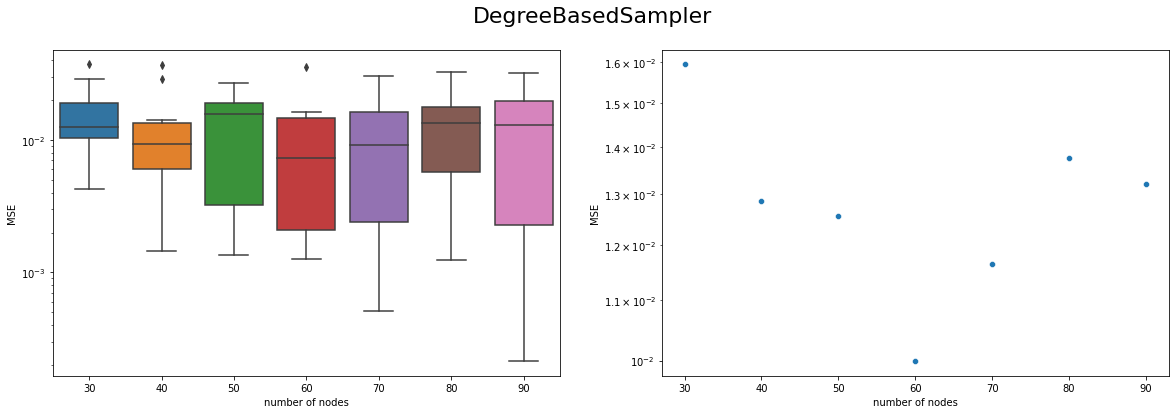

In [29]:
for name in MSE_methods_f3:
    plot(MSE_methods_f1[name],name)

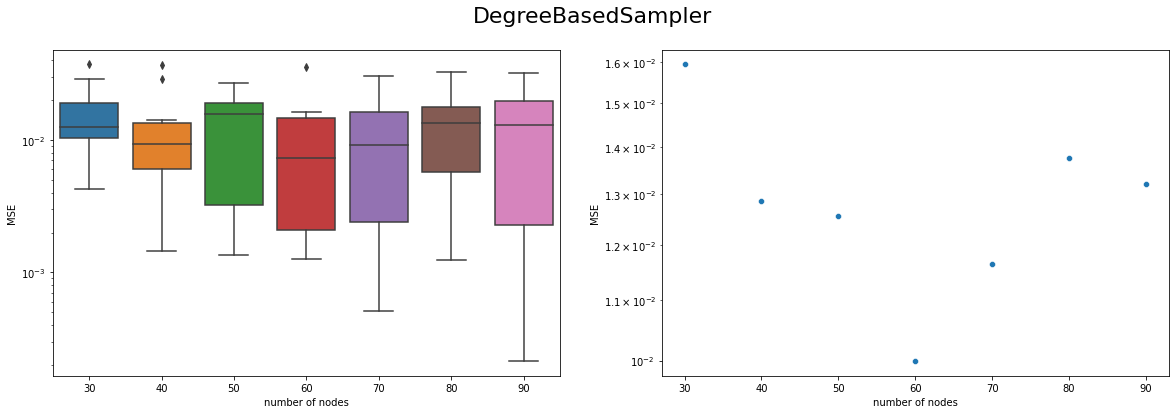

In [30]:
for name in MSE_methods_f1:
    plot(MSE_methods_f1[name],name)

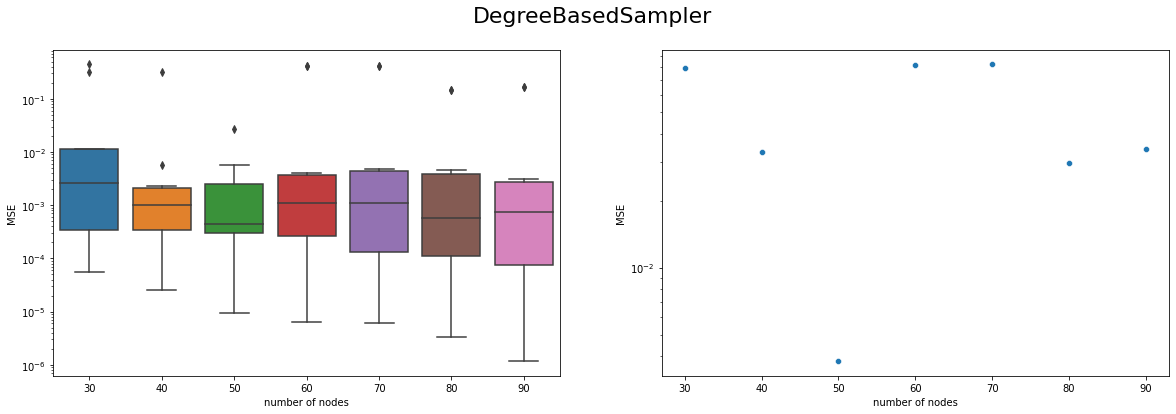

In [31]:
for name in MSE_methods_nodif:
    plot(MSE_methods_nodif[name],name)

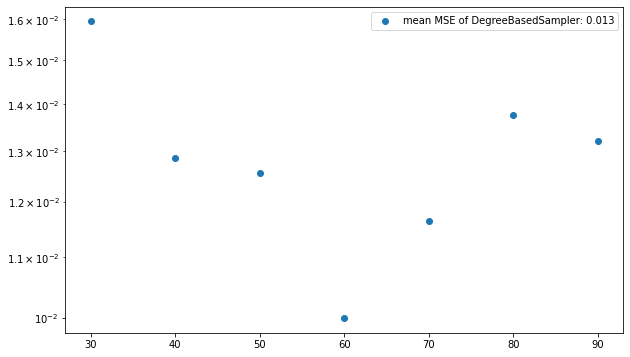

In [32]:
plt.figure(figsize=(10,6))
mean_MSEs = []
for name in MSE_methods_f1:
    MSE_dict = MSE_methods_f1[name]
    MSE = pd.DataFrame(MSE_dict , columns = list(MSE_dict.keys()))
    y = list(MSE.mean())
    x = list(map(lambda x: int(x),list(MSE.columns)))
    ax = plt.scatter(x=x, y=y)
    plt.yscale('log')
    mean_MSEs.append(sum(y)/len(y))
    
plt.legend(['mean MSE of ' + str(x[0]).split('.')[-1].split("'")[0] +': ' +str(np.round(x[1], decimals=3)) for x in zip(methods, mean_MSEs)])
plt.show()

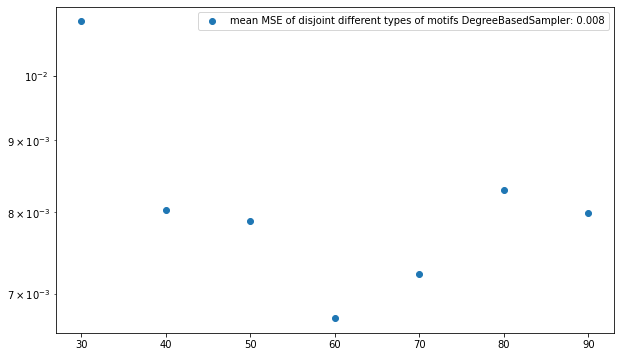

In [33]:
plt.figure(figsize=(10,6))
mean_MSEs = []
for name in MSE_methods_f3:
    MSE_dict = MSE_methods_f3[name]
    MSE = pd.DataFrame(MSE_dict , columns = list(MSE_dict.keys()))
    y = list(MSE.mean())
    x = list(map(lambda x: int(x),list(MSE.columns)))
    ax = plt.scatter(x=x, y=y)
    plt.yscale('log')
    mean_MSEs.append(sum(y)/len(y))
    
plt.legend(['mean MSE of disjoint different types of motifs ' + str(x[0]).split('.')[-1].split("'")[0] +': ' +str(np.round(x[1], decimals=3)) for x in zip(methods, mean_MSEs)])
plt.show()

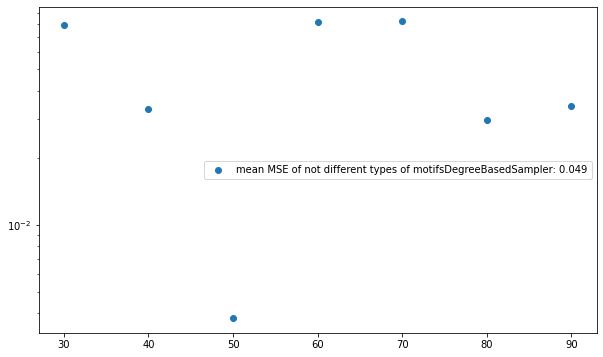

In [34]:
plt.figure(figsize=(10,6))
mean_MSEs = []
for name in MSE_methods_nodif:
    MSE_dict = MSE_methods_nodif[name]
    MSE = pd.DataFrame(MSE_dict , columns = list(MSE_dict.keys()))
    y = list(MSE.mean())
    x = list(map(lambda x: int(x),list(MSE.columns)))
    ax = plt.scatter(x=x, y=y)
    plt.yscale('log')
    mean_MSEs.append(sum(y)/len(y))
    
plt.legend(['mean MSE of not different types of motifs' + str(x[0]).split('.')[-1].split("'")[0] +': ' +str(np.round(x[1], decimals=3)) for x in zip(methods, mean_MSEs)])
plt.show()

# Regression

### counting number of iterations

In [35]:
with ThreadPoolExecutor(max_workers=4) as executor:
    res = executor.map(Utils.count, list(zip(*graphs))[1])

In [36]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

In [37]:
y = []
for n_iter in res:
    y.append(n_iter)

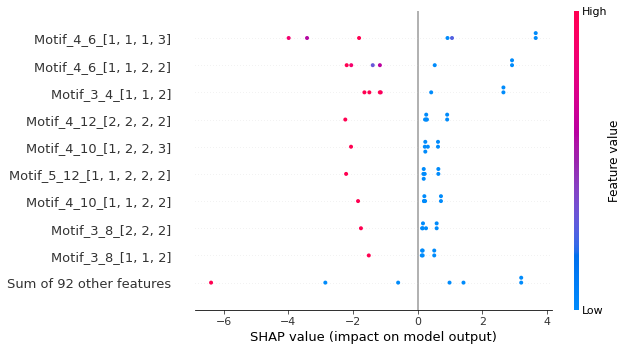

Different types, overlapping motifs. Method:  DegreeBasedSampler  Number of nodes: 30  MAPE  63.814402161870746


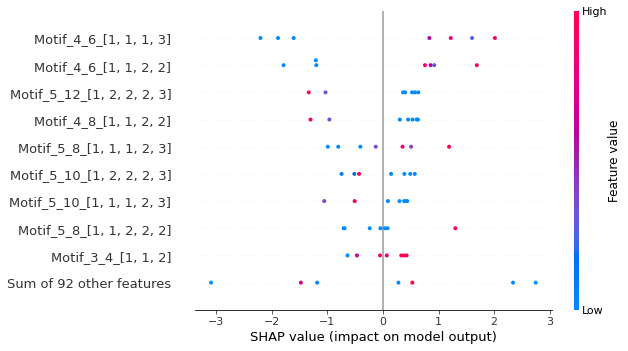

Different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 30  MAPE  38.184892418243585


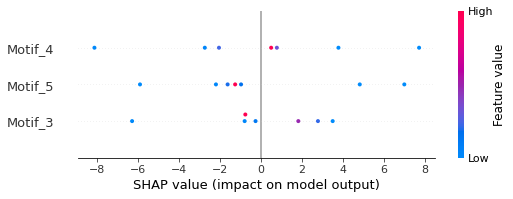

Not different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 30  MAPE  17.438689032497138


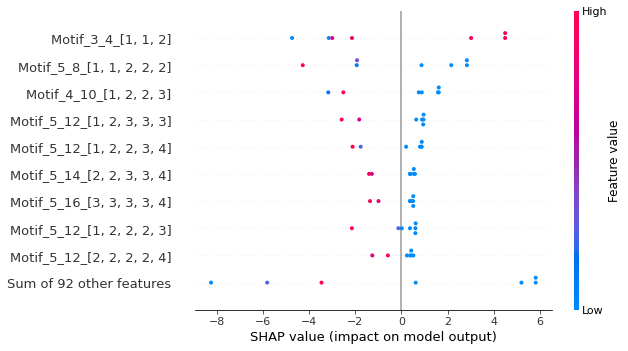

Different types, overlapping motifs. Method:  DegreeBasedSampler  Number of nodes: 40  MAPE  17.597349930419533


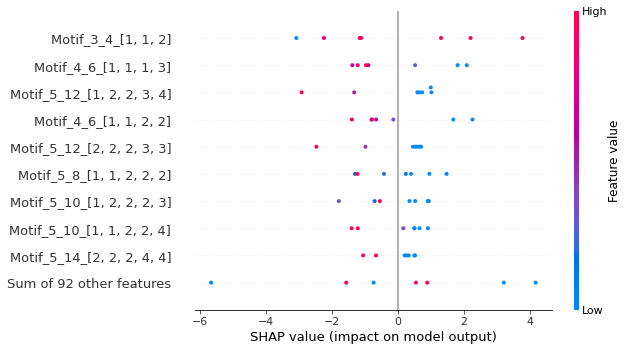

Different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 40  MAPE  32.01870320315016


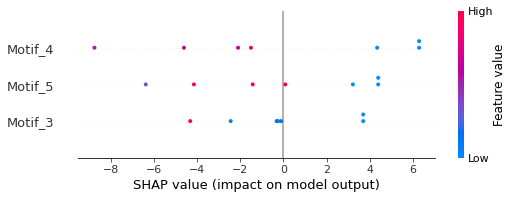

Not different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 40  MAPE  68.33356947817215


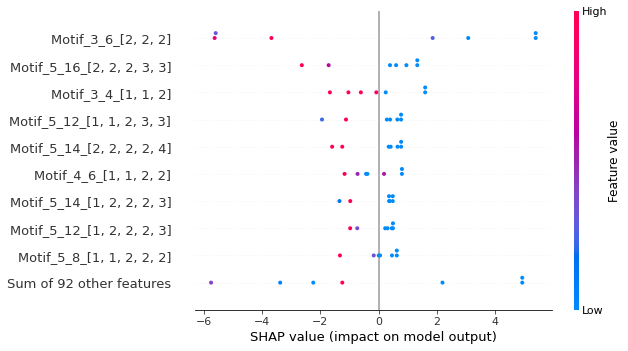

Different types, overlapping motifs. Method:  DegreeBasedSampler  Number of nodes: 50  MAPE  36.30050159000225


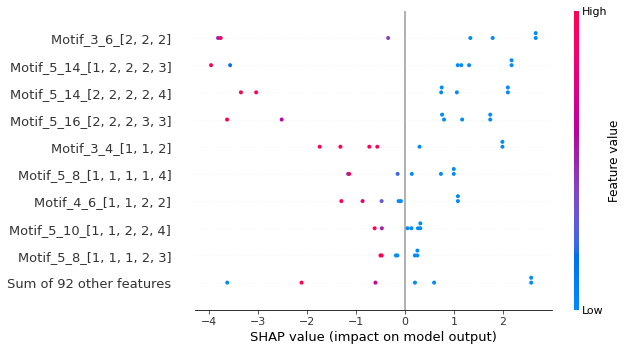

Different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 50  MAPE  40.27216911665907


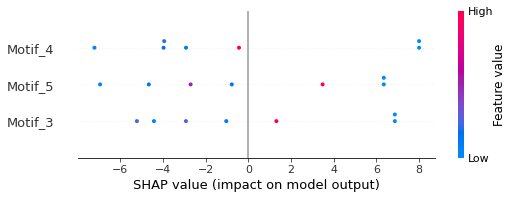

Not different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 50  MAPE  7.783863025192188


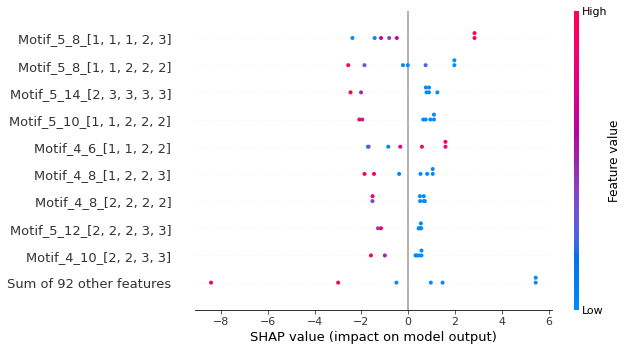

Different types, overlapping motifs. Method:  DegreeBasedSampler  Number of nodes: 60  MAPE  20.358527586594168


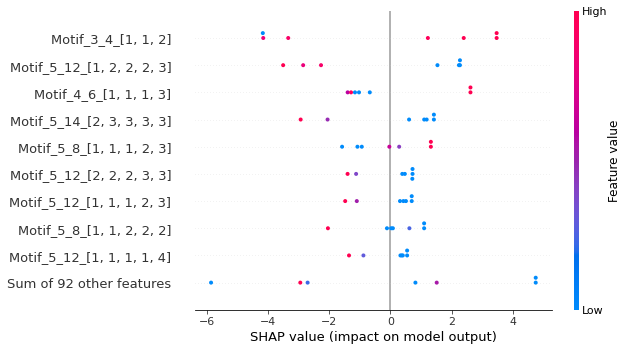

Different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 60  MAPE  9.957762381824631


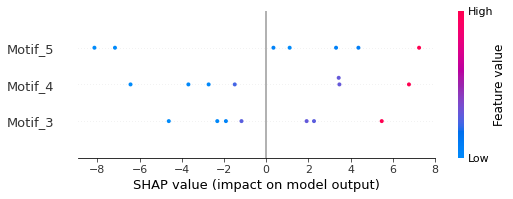

Not different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 60  MAPE  9.695111885649894


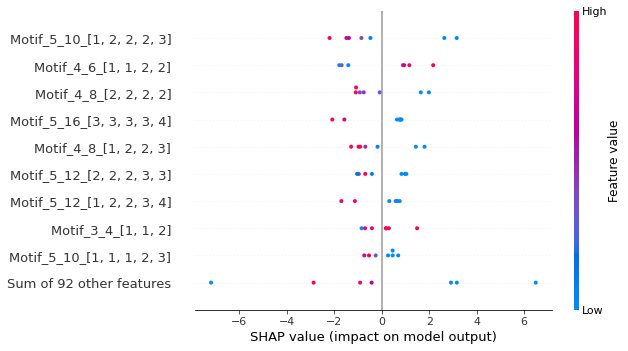

Different types, overlapping motifs. Method:  DegreeBasedSampler  Number of nodes: 70  MAPE  22.468968974295866


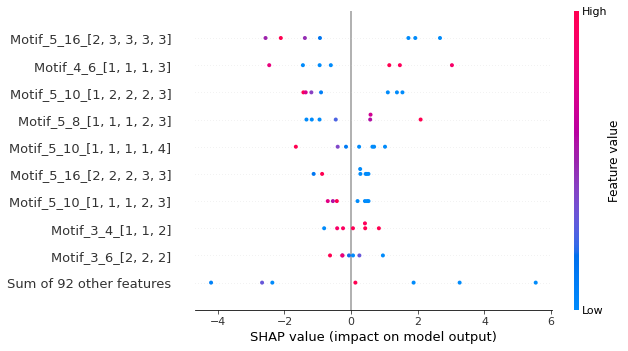

Different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 70  MAPE  30.676697611157838


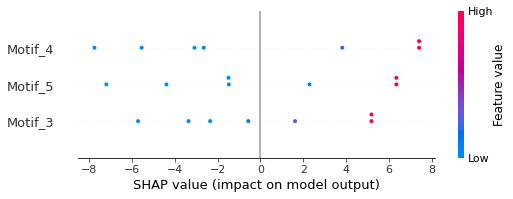

Not different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 70  MAPE  13.157260177341454


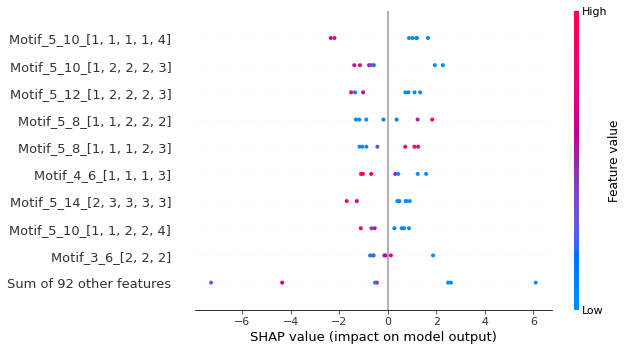

Different types, overlapping motifs. Method:  DegreeBasedSampler  Number of nodes: 80  MAPE  11.03410363908707


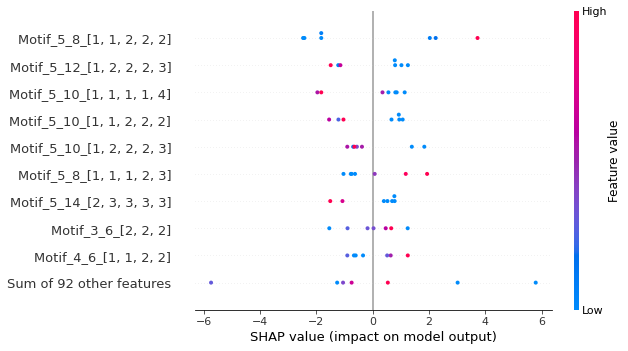

Different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 80  MAPE  14.44934269879765


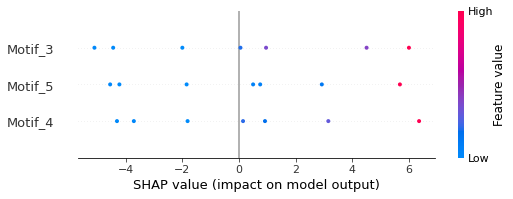

Not different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 80  MAPE  22.44594746598003


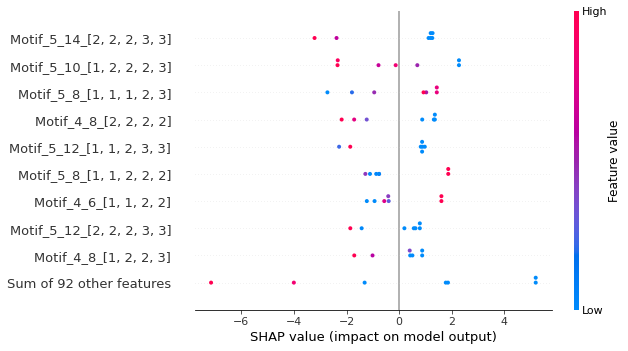

Different types, overlapping motifs. Method:  DegreeBasedSampler  Number of nodes: 90  MAPE  12.425718898411485


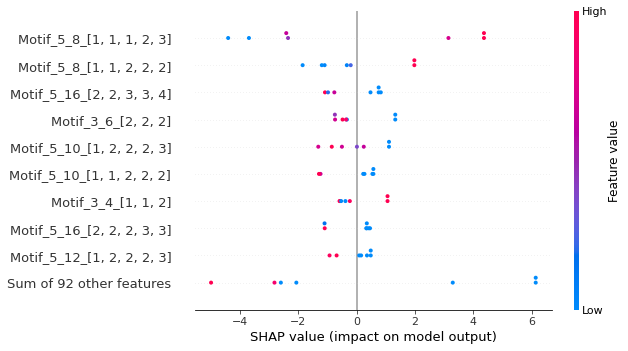

Different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 90  MAPE  33.09468827391379


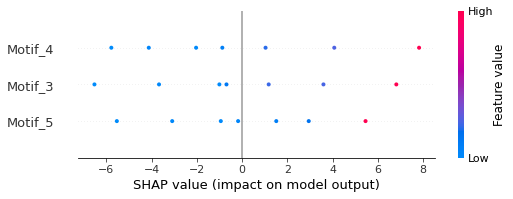

Not different types, disjoint motifs. Method:  DegreeBasedSampler  Number of nodes: 90  MAPE  8.614853997242493


KeyError: 'PageRankBasedSampler'

In [39]:
import shap
for method in methods:
    name_of_method=str(method).split('.')[-1].split("'")[0]
    for n in list(range(l,r,step)):
        X_f1 = X_sample_f1_to_save[name_of_method]['Number of nodes: ' + str(n)]
        X_train, X_test, y_train, y_test = train_test_split(X_f1, y, test_size=0.3)
        
        X_train = pd.DataFrame(X_train, columns=names_of_all_motifs_diff)
        # Initialize CatBoostRegressor
        model = CatBoostRegressor(iterations=100,silent=True)
        # Fit model
        model.fit(X_train, y_train)
        #Get predictions
        preds = model.predict(X_test)
        #SHAP explainer: 
        explainer = shap.Explainer(model)
        shap_values = explainer(X_train)
        shap.plots.beeswarm(shap_values)
        print('Different types, overlapping motifs. Method: ' ,name_of_method,' Number of nodes: ' + str(n), ' MAPE ', Utils.mean_absolute_percentage_error(y_test,preds))
        
        X_f3 =  X_sample_f3_to_save[name_of_method]['Number of nodes: ' + str(n)]
        X_train, X_test, y_train, y_test = train_test_split(X_f1, y, test_size=0.3)
        X_train = pd.DataFrame(X_train, columns=names_of_all_motifs_diff)
        #CatBoostRegressor
        model = CatBoostRegressor(iterations=100,silent=True)
        model.fit(X_train, y_train)
        #Get predictions
        preds = model.predict(X_test)
        #SHAP explainer:
        explainer = shap.Explainer(model)
        shap_values = explainer(X_train)
        shap.plots.beeswarm(shap_values)
        print('Different types, disjoint motifs. Method: ' ,name_of_method,' Number of nodes: ' + str(n), ' MAPE ', Utils.mean_absolute_percentage_error(y_test,preds))
        
        
        X =  X_sample_to_save[name_of_method]['Number of nodes: ' + str(n)]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        X_train = pd.DataFrame(X_train, columns=names_of_all_motifs)
        # CatBoostRegressor
        model = CatBoostRegressor(iterations=100,silent=True)
        model.fit(X_train, y_train)
        #Get predictions
        preds = model.predict(X_test)
        explainer = shap.Explainer(model)
        shap_values = explainer(X_train)
        # summarize the effects of all the features
        shap.plots.beeswarm(shap_values)
        print('Not different types, disjoint motifs. Method: ' ,name_of_method,' Number of nodes: ' + str(n), ' MAPE ', Utils.mean_absolute_percentage_error(y_test,preds))
        
        